In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

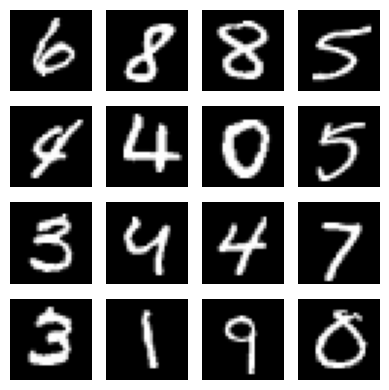

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

batch_plot, _ = next(iter(train_loader))

fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    image = batch_plot[i].permute(1, 2, 0).numpy()  
    ax.imshow(image, cmap='gray')  
    ax.axis('off') 

plt.tight_layout()
plt.show()

# Naive AE

In [4]:
def ReLU(z):
	a = np.maximum(0, z)
	return a 

def initialize_weights(config_layers):
    W = []
    n_layers = len(config_layers)
    for i in range(n_layers - 1):
        # getting pair dimensions 
        in_d, out_d = config_layers[i], config_layers[i+1]
        w_i = np.random.rand(in_d, out_d)
        W.append(w_i)
    return W

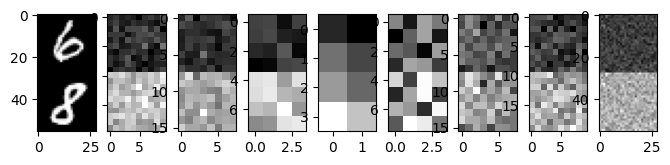

In [5]:
batch_len = 2
batch_test = batch_plot[:batch_len].reshape(-1, 784)
batch_test.shape

# ENCODER
w1, w2, w3, w4 = initialize_weights([784, 100, 64, 16, 4])
z1 = batch_test @ w1
a1 = ReLU(z1)
z2 = a1 @ w2
a2 = ReLU(z2)
z3 = a2 @ w3
a3 = ReLU(z3)
z4 = a3 @ w4
a4 = ReLU(z4)

# DECODER 
w5, w6, w7, w8 = initialize_weights([4, 16, 64, 100, 784])
z5 = a4 @ w5
a5 = ReLU(z5)
z6 = a5 @ w6 
a6 = ReLU(z6)
z7 = a6 @ w7
a7 = ReLU(z7)
z8 = a7 @ w8
a8 = ReLU(z8)

activations = [batch_test, a1, a2, a3, a4, a5, a6, a7, a8]
fig, axes = plt.subplots(1, 9, figsize=(8,8))
for a, ax in zip( activations, axes.flat):
    a = (a.reshape(-1, int(a.shape[1]**0.5)))
    ax.imshow(a, cmap="gray")
    #ax.imshow(a)

In [6]:
print(batch_test.shape)
print(w1.shape)

torch.Size([2, 784])
(784, 100)


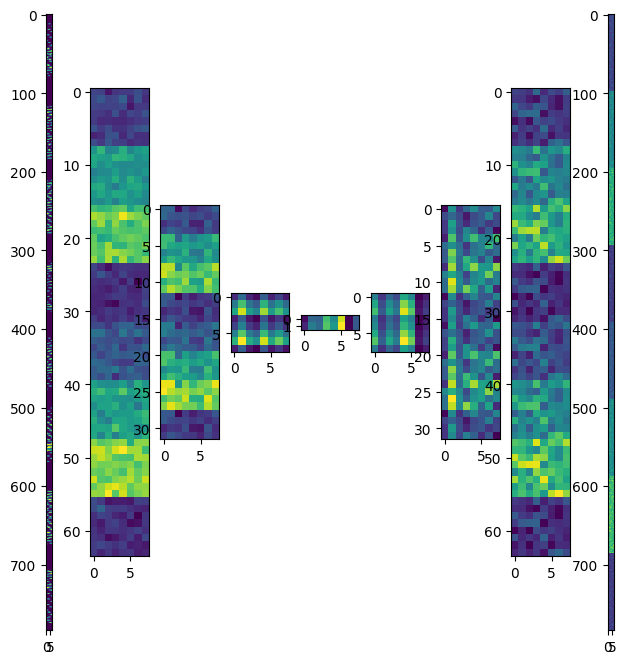

In [7]:
batch_len = 8
batch_test = batch_plot[:batch_len].reshape(-1, 784)
batch_test.shape

# ENCODER
w1, w2, w3, w4 = initialize_weights([784, 64, 32, 8, 2])
z1 = batch_test @ w1
a1 = ReLU(z1)
z2 = a1 @ w2
a2 = ReLU(z2)
z3 = a2 @ w3
a3 = ReLU(z3)
z4 = a3 @ w4
a4 = ReLU(z4)

# DECODER 
w5, w6, w7, w8 = initialize_weights([2, 8, 32, 64, 784])
z5 = a4 @ w5
a5 = ReLU(z5)
z6 = a5 @ w6 
a6 = ReLU(z6)
z7 = a6 @ w7
a7 = ReLU(z7)
z8 = a7 @ w8
a8 = ReLU(z8)


activations = [batch_test, a1, a2, a3, a4, a5, a6, a7, a8]
fig, axes = plt.subplots(1, 9, figsize=(8,8))
for a, ax in zip( activations, axes.flat):
    a = a.reshape(-1, a.shape[0])
    # ax.imshow(a, cmap="gray")
    ax.imshow(a)

# AE

In [8]:
class NeuralNetwork():
    def __init__(self, 
                a_type = "ReLU", 
                loss_type = "MSE", 
                config_layers = [784, 64, 32, 8, 2, 8, 32, 64, 784]) -> None:

        self.config_layers = config_layers
        self.weights = self.__initialize_weights()
        self.loss_type = loss_type
        self.a_type = a_type
        self.total_layers = len(self.config_layers) 
        self.a_cache = []
        self.z_cache = []

        # gradients
        self.djdout = 0
        self.dadz_list = []
        self.dzda_prev_list = []
        self.dzdw_list = []

        self.input = None
        self.output = None
        self.x = None
        self.m = None
    
    def __call__(self, x):
        self.output = self.__forward(x)
        self.x = x
        # (n_B, n_W * n_H)
        self.m = x.shape[0]
        return self.output
    
    def __initialize_weights(self):
        W = []
        n_layers = len(self.config_layers)
        for i in range(n_layers - 1):
            in_d, out_d = self.config_layers[i], self.config_layers[i+1]
            w_i_layer = np.random.uniform(-1, 1, size=(in_d, out_d))
            b_i_layer = np.zeros( out_d )
            W.append( (w_i_layer, b_i_layer) )
        return W
        
    def activation(self, z):
        if self.a_type == "ReLU":
            return np.maximum(0, z)
        
        if self.a_type == "Sigmoid":
            pass 

        # ...

    def loss(self):
        if self.loss_type == "MSE":
            error = self.output - self.input
            print(self.output.shape)
            print(self.input.shape)
            print((error @ error.T).shape)
            mean_batch_error = np.sum(error @ error.T)
            return mean_batch_error
        
        if self.loss_type == "MAE":
            pass

        # ...
    
    def dloss(self):
        # first derivative
        # dj/da_{last-layer}
        # dj/da_{a8} == dj/da_{output}
        error = self.output - self.input
        print(self.output.shape)
        print(self.input.shape)
        # sum_batch_error = np.sum(error, axis=1, keepdims=True)
        # mean_batch_error =  (1/self.m) * np.sum(sum_batch_error) * 1
        mean_batch_error = np.sum(error @ error.T)
        print(mean_batch_error.shape)

        return mean_batch_error 
    
    def backward(self):
        # (FIRST) diff dj/doutput
        self.djdout = self.loss()

        # (MID) hidden derivatives
        for l in range(self.total_layers - 2, -1, -1):

            z = self.z_cache[l]
            w, b = self.weights[l]
            # print(z.shape)
            # d(ReLU(0, zi)) / dzi = 1 (zi > 0)
            self.dadz_list.append( z > 0 )
            # d(wiai + ... + wixi) / dai  = wi
            self.dzda_prev_list.append( w )

            if l >= 1:
                a_prev = self.a_cache[l - 1]
                # d(w1a1 + ... + wiai) / dwi = ai
                self.dzdw_list.append( a_prev ) 

        # (LAST) leaf-derivatives
        # d(w1x1 + ... + wixi) / dwi = xi
        self.dzdw_list.append( self.input )



    def backward(self):
        self.djdout = self.dloss()
        for l in range(self.total_layers - 2, -1, -1):
            z = self.z_cache[l]
            w, b = self.weights[l]
            self.dadz_list.append( z > 0 )
            self.dzda_prev_list.append( w )

            if l >= 1:
                a_prev = self.a_cache[l - 1]
                self.dzdw_list.append( a_prev ) 

        self.dzdw_list.append( self.input )


    def optimizer(self):
        pass


    def __cache(self, z, a):
        self.z_cache.append( z )
        self.a_cache.append( a )

    
    def __forward(self, x):
        self.input = x
        for w, b in self.weights:
            z = x @ w + b 
            x = self.activation(z)
            self.__cache( z, a = x )
        self.output = x
        return self.output

## AE test

In [9]:
ae_test = NeuralNetwork(a_type="ReLU", 
                        loss_type = "MSE", 
                        config_layers=[784, 64, 32, 2, 32, 64, 784])

x_train, _ = next(iter(train_loader))        
x_train.shape

torch.Size([16, 1, 28, 28])

In [10]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_train = x_train.numpy()
x_train.shape

(16, 784)

In [11]:
pred = ae_test(x_train)
np.sum((x_train - pred) ** 2, axis=1)

array([8.48211159e+01, 7.14603339e+06, 2.84463808e+07, 2.10389351e+06,
       6.50145869e+06, 1.06810446e+05, 2.17796713e+02, 1.07296167e+07,
       1.10754667e+06, 1.48378940e+06, 2.36600952e+07, 1.04776823e+07,
       7.80445224e+01, 1.01346695e+07, 1.54713150e+06, 1.14798427e+05])

In [12]:
ae_test.loss()

(16, 784)
(16, 784)
(16, 16)


924211308.722712

In [14]:
ae_test.backward()

(16, 784)
(16, 784)
()


In [15]:
"""
(1,1) (1,784) (64,784) (1,64) (1,32)
      (1,784) (784,64)
      (1,64) (64,1)
      (1,1) (1,32)

"""

'\n(1,1) (1,784) (64,784) (1,64) (1,32)\n      (1,784) (784,64)\n      (1,64) (64,1)\n      (1,1) (1,32)\n\n'

In [16]:
# ae_test.dzda_prev_list
# ae_test.dadz_list
# ae_test.dzdw_list

# GRADIENTE TAMANHO IGUAL A DIMENSAO DOS PESOS

print(len(ae_test.dadz_list),len(ae_test.dzda_prev_list), len(ae_test.dzdw_list))

print("djda           dadz         dzda          dzdw")
djda = ae_test.djdout
print(int(djda))
dadz_l, dzda_l, dzdw_l = ae_test.dadz_list, ae_test.dzda_prev_list, ae_test.dzdw_list 
for dadz, dzda, dzdw in zip(dadz_l, dzda_l, dzdw_l):
    print("             ",dadz.shape, "  ", dzda.shape, " ",dzdw.shape)
    # print("                  ",dzdw.T.shape, "     ", dadz.shape)
    # print("                  ", (dzdw.T @ dadz).shape )
    print(" ")

#           (1,1)     (1, 784)        (1, 64)
# dj/dw8 = dj/da8 *    da8/dz8    *   dz8/dw8


#           (1,1)      (1, 784)         (1,)
# dj/dw7 = dj/da8 *    da8/dz8    *   dz8/da7 * da7/dz7 * dz7/dw7


12 12 12
djda           dadz         dzda          dzdw
924211308
              (16, 784)    (64, 784)   (16, 64)
 
              (16, 64)    (32, 64)   (16, 32)
 
              (16, 32)    (2, 32)   (16, 2)
 
              (16, 2)    (32, 2)   (16, 32)
 
              (16, 32)    (64, 32)   (16, 64)
 
              (16, 64)    (784, 64)   (16, 784)
 
              (16, 784)    (64, 784)   (16, 64)
 
              (16, 64)    (32, 64)   (16, 32)
 
              (16, 32)    (2, 32)   (16, 2)
 
              (16, 2)    (32, 2)   (16, 32)
 
              (16, 32)    (64, 32)   (16, 64)
 
              (16, 64)    (784, 64)   (16, 784)
 


In [17]:
# ae_test.dzda_prev_list
# ae_test.dadz_list
# ae_test.dzdw_list

# GRADIENTE TAMANHO 1

print(len(ae_test.dadz_list),len(ae_test.dzda_prev_list), len(ae_test.dzdw_list))

print("djda           dadz         dzda          dzdw")
djda = ae_test.djdout
print(int(djda))
dadz_l, dzda_l, dzdw_l = ae_test.dadz_list, ae_test.dzda_prev_list, ae_test.dzdw_list 
for dadz, dzda, dzdw in zip(dadz_l, dzda_l, dzdw_l):
    print("             ",dadz.shape, "  ", dzda.shape, " ",dzdw.shape)
    print("                  ",(dadz @ dzda.T).shape, "     ", dzdw.T.shape)
    print("                  ", ((dadz @ dzda.T) @ dzdw.T).shape )


    print(" ")


#           (1,1)     (1, 784)        (1, 64)
# dj/dw8 = dj/da8 *    da8/dz8    *   dz8/dw8


#           (1,1)      (1, 784)         (1,)
# dj/dw7 = dj/da8 *    da8/dz8    *   dz8/da7 * da7/dz7 * dz7/dw7


12 12 12
djda           dadz         dzda          dzdw
924211308
              (16, 784)    (64, 784)   (16, 64)
                   (16, 64)       (64, 16)
                   (16, 16)
 
              (16, 64)    (32, 64)   (16, 32)
                   (16, 32)       (32, 16)
                   (16, 16)
 
              (16, 32)    (2, 32)   (16, 2)
                   (16, 2)       (2, 16)
                   (16, 16)
 
              (16, 2)    (32, 2)   (16, 32)
                   (16, 32)       (32, 16)
                   (16, 16)
 
              (16, 32)    (64, 32)   (16, 64)
                   (16, 64)       (64, 16)
                   (16, 16)
 
              (16, 64)    (784, 64)   (16, 784)
                   (16, 784)       (784, 16)
                   (16, 16)
 
              (16, 784)    (64, 784)   (16, 64)
                   (16, 64)       (64, 16)
                   (16, 16)
 
              (16, 64)    (32, 64)   (16, 32)
                   (16, 32)       (32, 16)
          

In [18]:
dadz_l, dzda_l, dzdw_l = ae_test.dadz_list, ae_test.dzda_prev_list, ae_test.dzdw_list 
for dadz, dzda, dzdw in zip(dadz_l, dzda_l, dzdw_l):
    print((dadz @ dzda.T).shape, "       ",dadz.shape, "  ", dzda.T.shape, " ",dzdw.T.shape)
    break

(16, 64)         (16, 784)    (784, 64)   (64, 16)


In [ ]:
# updating pesos da ultima camada 
print(dadz_l[0].shape)
print((djda * dadz_l[0]).shape)
(dzdw_l[0].T @ (djda * dadz_l[0])).shape

In [ ]:
# updating pesos da penultima camada 
grad0 = djda * dadz_l[0] # (1, 784)
# dzda_l[0]           w7 = (64, 784)


In [ ]:
# atualizando os pesos da ultima camada 
ae_test.weights[6][0] -  0.66 * (dadz * djda)

In [ ]:
(dadz * djda).shape

In [ ]:
for w, b in ae_test.weights:
    print(w.shape, b.shape)

In [ ]:
# W8 = W8 - lr * grad
W8 = ae_test.weights[7] 
#         grad1     grad2     grad3
# djdw8 = dj/da8 * da8/dz8 * dz8/dw8
grad1 = ae_test.djdout
grad2 = ae_test.dadz_list[0]
grad3 = ae_test.dzdw_list[0]
print(grad1, grad2.shape, grad3.shape)
# 10866417.998216636 (1, 784) (1, 64)

# how can be possible to multiply the gradients to update the w8 weights
W8 = W8 - 0.001 * (grad1 @ grad2.T @ grad3.T) 


In [ ]:
class Encoder(NeuralNetwork):
    def __init__(self, a_type="ReLU", loss_type = "MSE", config_layers=[784, 64, 32, 8, 2]) -> None:
        super().__init__(a_type, loss_type, config_layers)

class Decoder(NeuralNetwork):
    def __init__(self, a_type="ReLU", loss_type = "MSE", config_layers=[2, 8, 32, 64, 784]) -> None:
        super().__init__(a_type, loss_type, config_layers)